### Import required Libraries

In [38]:
import h5py
import requests
import os

In [39]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math, time, itertools
import datetime
from operator import itemgetter

In [40]:
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn import linear_model;
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [41]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.models import load_model

### Load Dataset

In [42]:
df = pd.read_csv("./dataset/prices-split-adjusted.csv", index_col = 0)

In [43]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [44]:
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [45]:
#number of companies in the dataset
len(set(df['symbol']))

501

### Select a company for which we'll be predicting stock prices

In [46]:
#choosing a specific company for which prices will be predicted - here SYMC
df = df[df['symbol'] == 'SYMC']
df['Mid']=(df['high']+df['low'])/2
df.sort_values(by='date',inplace=True)

### Prepare Train and Test Dataset

In [47]:
def prepare_data(df,predict_col,predict_window,test_size):
    label = df[predict_col].shift(-predict_window);
    X = np.array(df[[predict_col]]); 
    X = preprocessing.scale(X) 
    X_lately = X[-predict_window:] 
    X = X[:-predict_window] 
    label.dropna(inplace=True); 
    y = np.array(label) 
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y, test_size=test_size)
    response = [X_train,X_test , Y_train, Y_test , X_lately];
    return response;

### Prepare Dataset and add a new column, Mid = (low + high)/2 to the data

In [48]:
target_col = 'Mid'
predict_window = 20
test_size = 0.2;

X_train, X_test, Y_train, Y_test , X_lately =prepare_data(df, target_col, predict_window, test_size); 

# Model 1: Linear Regression

In [49]:
linear_reg_model = linear_model.LinearRegression(); 

The test score is:  0.8481099148586401


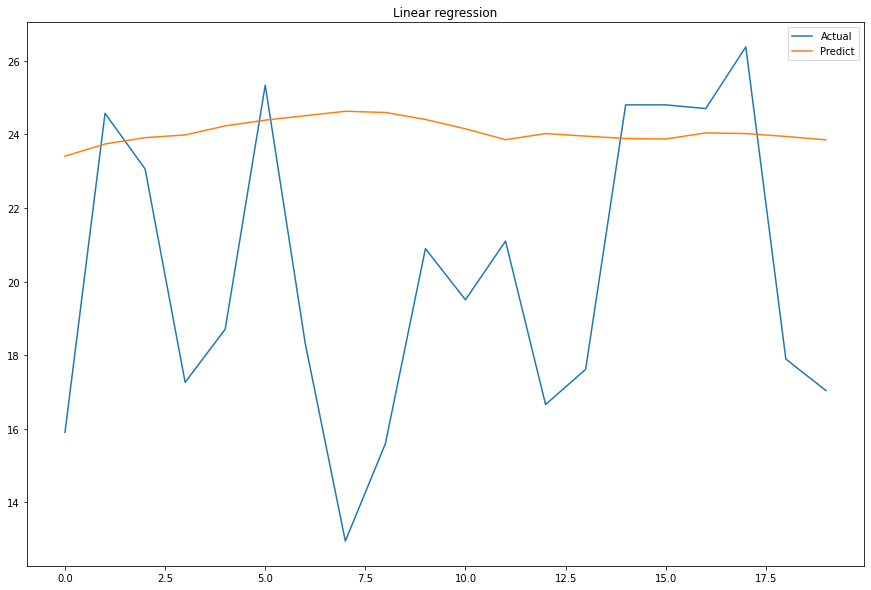

In [50]:
linear_reg_model.fit(X_train,Y_train); 
score = linear_reg_model.score(X_test,Y_test);

predicted= linear_reg_model.predict(X_lately); 

response={};
response['test_score']=score; 
response['predicted_set']=predicted;
print("The test score is: ",format(score))

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(111)
ax.plot(Y_test[:predict_window],label='Actual')
ax.plot(predicted,label='Predict')
plt.title('Linear regression')
ax.legend()

# Model 2 - Standard Average

### Prepare Dataset

In [51]:
train_start = 0
train_end=df.shape[0]-1

n= df.shape[0]
test_start = train_end
test_end = n

data_train = df.iloc[np.arange(train_start, train_end), :]
data_test = df.iloc[np.arange(test_start, test_end), :]

data_train=data_train.reset_index()
data_test=data_test.reset_index()

scaler = MinMaxScaler()
training_val=scaler.fit_transform(data_train['Mid'].to_numpy().reshape(-1,1))
test_val=scaler.transform(data_test['Mid'].to_numpy().reshape(-1,1))

In [52]:
data_train.head()

,date,symbol,open,close,low,high,volume,Mid
0,2010-01-04,SYMC,18.040001,18.400000,18.010000,18.530001,8322300.0,18.270001
1,2010-01-05,SYMC,18.400000,18.299999,18.139999,18.440001,6621200.0,18.290000
2,2010-01-06,SYMC,18.219999,18.360001,18.139999,18.459999,6043600.0,18.299999
3,2010-01-07,SYMC,18.469999,18.320000,18.129999,18.469999,8085300.0,18.299999
4,2010-01-08,SYMC,18.250000,18.370001,18.209999,18.500000,6030900.0,18.354999


In [53]:
window_size = 75
N = training_val.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):
    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.index.values[pred_idx]
    std_avg_predictions.append(np.mean(training_val[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-training_val[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00594


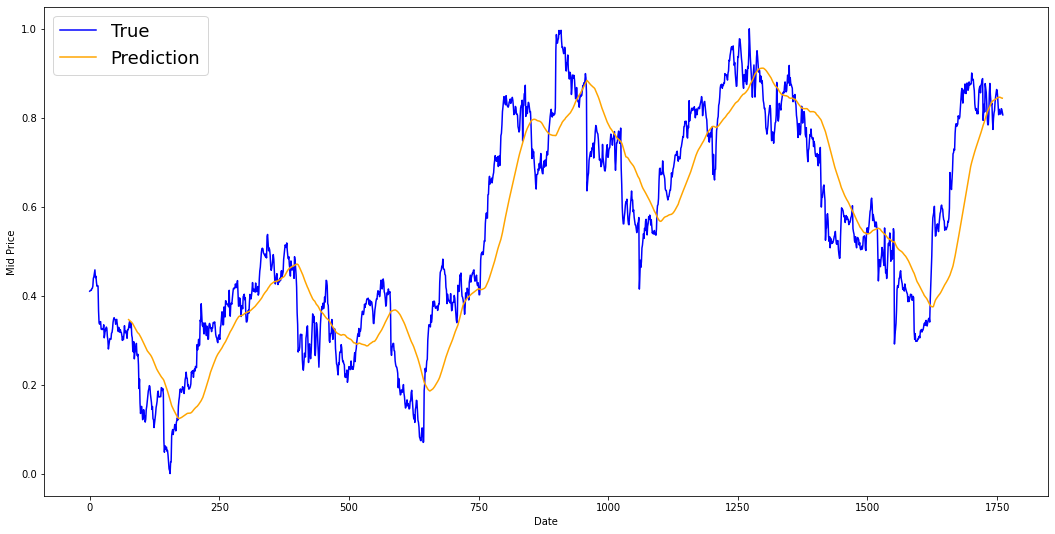

In [54]:
all_mid_data = np.concatenate([training_val,test_val],axis=0)
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

# Model 3 - Exponential moving average

In [55]:
window_size = 100
N = training_val.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):
    running_mean = running_mean*decay + (1.0-decay)*training_val[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-training_val[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00032


/home/pooja/.local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


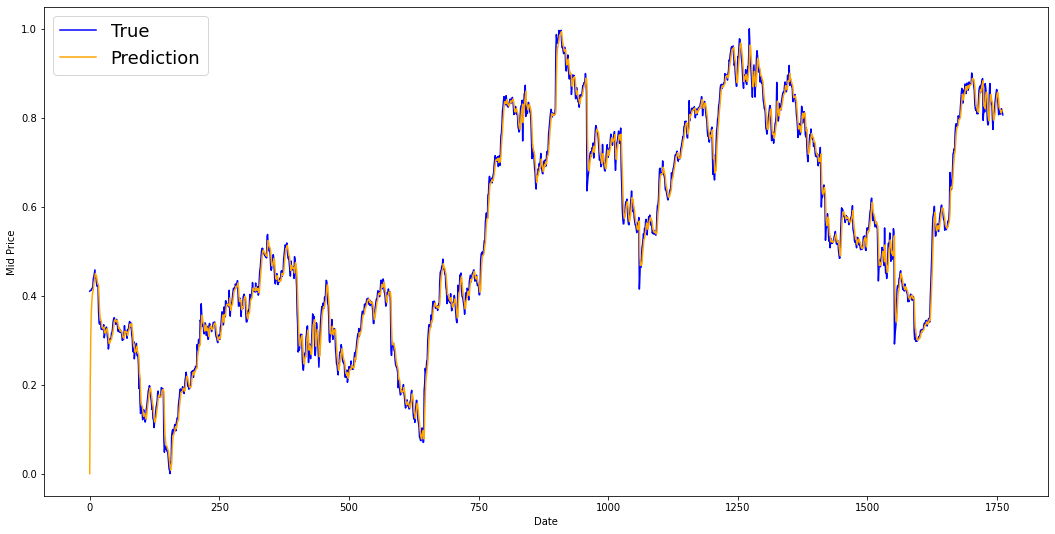

In [56]:
all_mid_data = np.concatenate([training_val,test_val],axis=0)

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

# Model 4 - LSTM

### Preparing Data

In [57]:
train_start = 0
train_end = 1000

test_start = train_end
test_end = n

data_train = df.iloc[np.arange(train_start, train_end), :]
data_test = df.iloc[np.arange(test_start, test_end), :]

data_train=data_train.reset_index()
data_test=data_test.reset_index()

scaler = StandardScaler()

training_val=scaler.fit_transform(data_train['Mid'].to_numpy().reshape(-1,1))
test_val=scaler.transform(data_test['Mid'].to_numpy().reshape(-1,1))

### Plotting Train and Test Data

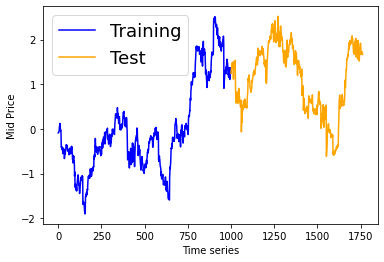

In [58]:
plt.plot(range(0,training_val.shape[0]),training_val,color='b',label='Training')
plt.plot(range(training_val.shape[0],training_val.shape[0]+test_val.shape[0]),test_val,color='orange',label='Test')
plt.xlabel('Time series')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

### In this model, we are predicting the stock price of current date from the data of last n days (n=50)

In [59]:
training_set=data_train['Mid'].to_numpy().reshape(-1,1)
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)
ndays = 50

X_train = []
y_train = []

for i in range(ndays, train_end):
    X_train.append(training_set_scaled[i-ndays:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

### LSTM Model

In [60]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=60, return_sequences=False, input_shape=(X_train.shape[1],1)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 60)                14880     
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                                 
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [62]:
model.fit(X_train,y_train,epochs=1000,batch_size=128,verbose=2)

Epoch 1/1000
8/8 - 2s - loss: 0.8672 - 2s/epoch - 204ms/step
Epoch 2/1000
8/8 - 0s - loss: 0.2774 - 154ms/epoch - 19ms/step
Epoch 3/1000
8/8 - 0s - loss: 0.0980 - 152ms/epoch - 19ms/step
Epoch 4/1000
8/8 - 0s - loss: 0.0792 - 156ms/epoch - 19ms/step
Epoch 5/1000
8/8 - 0s - loss: 0.0593 - 158ms/epoch - 20ms/step
Epoch 6/1000
8/8 - 0s - loss: 0.0625 - 156ms/epoch - 19ms/step
Epoch 7/1000
8/8 - 0s - loss: 0.0554 - 159ms/epoch - 20ms/step
Epoch 8/1000
8/8 - 0s - loss: 0.0513 - 158ms/epoch - 20ms/step
Epoch 9/1000
8/8 - 0s - loss: 0.0487 - 154ms/epoch - 19ms/step
Epoch 10/1000
8/8 - 0s - loss: 0.0500 - 176ms/epoch - 22ms/step
Epoch 11/1000
8/8 - 0s - loss: 0.0464 - 157ms/epoch - 20ms/step
Epoch 12/1000
8/8 - 0s - loss: 0.0456 - 164ms/epoch - 20ms/step
Epoch 13/1000
8/8 - 0s - loss: 0.0435 - 166ms/epoch - 21ms/step
Epoch 14/1000
8/8 - 0s - loss: 0.0436 - 160ms/epoch - 20ms/step
Epoch 15/1000
8/8 - 0s - loss: 0.0423 - 155ms/epoch - 19ms/step
Epoch 16/1000
8/8 - 0s - loss: 0.0408 - 169ms/epoch

Epoch 129/1000
8/8 - 0s - loss: 0.0206 - 171ms/epoch - 21ms/step
Epoch 130/1000
8/8 - 0s - loss: 0.0214 - 176ms/epoch - 22ms/step
Epoch 131/1000
8/8 - 0s - loss: 0.0197 - 172ms/epoch - 21ms/step
Epoch 132/1000
8/8 - 0s - loss: 0.0217 - 178ms/epoch - 22ms/step
Epoch 133/1000
8/8 - 0s - loss: 0.0214 - 197ms/epoch - 25ms/step
Epoch 134/1000
8/8 - 0s - loss: 0.0220 - 183ms/epoch - 23ms/step
Epoch 135/1000
8/8 - 0s - loss: 0.0221 - 171ms/epoch - 21ms/step
Epoch 136/1000
8/8 - 0s - loss: 0.0201 - 176ms/epoch - 22ms/step
Epoch 137/1000
8/8 - 0s - loss: 0.0209 - 174ms/epoch - 22ms/step
Epoch 138/1000
8/8 - 0s - loss: 0.0210 - 177ms/epoch - 22ms/step
Epoch 139/1000
8/8 - 0s - loss: 0.0212 - 185ms/epoch - 23ms/step
Epoch 140/1000
8/8 - 0s - loss: 0.0217 - 180ms/epoch - 22ms/step
Epoch 141/1000
8/8 - 0s - loss: 0.0207 - 214ms/epoch - 27ms/step
Epoch 142/1000
8/8 - 0s - loss: 0.0217 - 186ms/epoch - 23ms/step
Epoch 143/1000
8/8 - 0s - loss: 0.0220 - 180ms/epoch - 23ms/step
Epoch 144/1000
8/8 - 0s -

8/8 - 0s - loss: 0.0178 - 188ms/epoch - 24ms/step
Epoch 256/1000
8/8 - 0s - loss: 0.0175 - 186ms/epoch - 23ms/step
Epoch 257/1000
8/8 - 0s - loss: 0.0190 - 175ms/epoch - 22ms/step
Epoch 258/1000
8/8 - 0s - loss: 0.0168 - 199ms/epoch - 25ms/step
Epoch 259/1000
8/8 - 0s - loss: 0.0178 - 184ms/epoch - 23ms/step
Epoch 260/1000
8/8 - 0s - loss: 0.0196 - 194ms/epoch - 24ms/step
Epoch 261/1000
8/8 - 0s - loss: 0.0164 - 211ms/epoch - 26ms/step
Epoch 262/1000
8/8 - 0s - loss: 0.0172 - 196ms/epoch - 25ms/step
Epoch 263/1000
8/8 - 0s - loss: 0.0189 - 188ms/epoch - 23ms/step
Epoch 264/1000
8/8 - 0s - loss: 0.0172 - 191ms/epoch - 24ms/step
Epoch 265/1000
8/8 - 0s - loss: 0.0179 - 182ms/epoch - 23ms/step
Epoch 266/1000
8/8 - 0s - loss: 0.0184 - 199ms/epoch - 25ms/step
Epoch 267/1000
8/8 - 0s - loss: 0.0158 - 190ms/epoch - 24ms/step
Epoch 268/1000
8/8 - 0s - loss: 0.0168 - 190ms/epoch - 24ms/step
Epoch 269/1000
8/8 - 0s - loss: 0.0179 - 190ms/epoch - 24ms/step
Epoch 270/1000
8/8 - 0s - loss: 0.0184 -

Epoch 382/1000
8/8 - 0s - loss: 0.0161 - 212ms/epoch - 27ms/step
Epoch 383/1000
8/8 - 0s - loss: 0.0172 - 208ms/epoch - 26ms/step
Epoch 384/1000
8/8 - 0s - loss: 0.0166 - 200ms/epoch - 25ms/step
Epoch 385/1000
8/8 - 0s - loss: 0.0167 - 191ms/epoch - 24ms/step
Epoch 386/1000
8/8 - 0s - loss: 0.0158 - 189ms/epoch - 24ms/step
Epoch 387/1000
8/8 - 0s - loss: 0.0150 - 198ms/epoch - 25ms/step
Epoch 388/1000
8/8 - 0s - loss: 0.0156 - 237ms/epoch - 30ms/step
Epoch 389/1000
8/8 - 0s - loss: 0.0160 - 240ms/epoch - 30ms/step
Epoch 390/1000
8/8 - 0s - loss: 0.0157 - 196ms/epoch - 25ms/step
Epoch 391/1000
8/8 - 0s - loss: 0.0157 - 193ms/epoch - 24ms/step
Epoch 392/1000
8/8 - 0s - loss: 0.0159 - 205ms/epoch - 26ms/step
Epoch 393/1000
8/8 - 0s - loss: 0.0162 - 231ms/epoch - 29ms/step
Epoch 394/1000
8/8 - 0s - loss: 0.0137 - 195ms/epoch - 24ms/step
Epoch 395/1000
8/8 - 0s - loss: 0.0169 - 225ms/epoch - 28ms/step
Epoch 396/1000
8/8 - 0s - loss: 0.0150 - 198ms/epoch - 25ms/step
Epoch 397/1000
8/8 - 0s -

8/8 - 0s - loss: 0.0147 - 187ms/epoch - 23ms/step
Epoch 509/1000
8/8 - 0s - loss: 0.0157 - 192ms/epoch - 24ms/step
Epoch 510/1000
8/8 - 0s - loss: 0.0146 - 189ms/epoch - 24ms/step
Epoch 511/1000
8/8 - 0s - loss: 0.0158 - 190ms/epoch - 24ms/step
Epoch 512/1000
8/8 - 0s - loss: 0.0163 - 188ms/epoch - 24ms/step
Epoch 513/1000
8/8 - 0s - loss: 0.0140 - 190ms/epoch - 24ms/step
Epoch 514/1000
8/8 - 0s - loss: 0.0158 - 190ms/epoch - 24ms/step
Epoch 515/1000
8/8 - 0s - loss: 0.0163 - 186ms/epoch - 23ms/step
Epoch 516/1000
8/8 - 0s - loss: 0.0155 - 188ms/epoch - 24ms/step
Epoch 517/1000
8/8 - 0s - loss: 0.0155 - 196ms/epoch - 24ms/step
Epoch 518/1000
8/8 - 0s - loss: 0.0163 - 188ms/epoch - 23ms/step
Epoch 519/1000
8/8 - 0s - loss: 0.0157 - 186ms/epoch - 23ms/step
Epoch 520/1000
8/8 - 0s - loss: 0.0152 - 182ms/epoch - 23ms/step
Epoch 521/1000
8/8 - 0s - loss: 0.0178 - 183ms/epoch - 23ms/step
Epoch 522/1000
8/8 - 0s - loss: 0.0145 - 190ms/epoch - 24ms/step
Epoch 523/1000
8/8 - 0s - loss: 0.0152 -

Epoch 635/1000
8/8 - 0s - loss: 0.0156 - 176ms/epoch - 22ms/step
Epoch 636/1000
8/8 - 0s - loss: 0.0153 - 186ms/epoch - 23ms/step
Epoch 637/1000
8/8 - 0s - loss: 0.0160 - 177ms/epoch - 22ms/step
Epoch 638/1000
8/8 - 0s - loss: 0.0161 - 181ms/epoch - 23ms/step
Epoch 639/1000
8/8 - 0s - loss: 0.0160 - 182ms/epoch - 23ms/step
Epoch 640/1000
8/8 - 0s - loss: 0.0152 - 179ms/epoch - 22ms/step
Epoch 641/1000
8/8 - 0s - loss: 0.0160 - 180ms/epoch - 22ms/step
Epoch 642/1000
8/8 - 0s - loss: 0.0170 - 175ms/epoch - 22ms/step
Epoch 643/1000
8/8 - 0s - loss: 0.0161 - 178ms/epoch - 22ms/step
Epoch 644/1000
8/8 - 0s - loss: 0.0152 - 180ms/epoch - 23ms/step
Epoch 645/1000
8/8 - 0s - loss: 0.0166 - 183ms/epoch - 23ms/step
Epoch 646/1000
8/8 - 0s - loss: 0.0132 - 178ms/epoch - 22ms/step
Epoch 647/1000
8/8 - 0s - loss: 0.0159 - 179ms/epoch - 22ms/step
Epoch 648/1000
8/8 - 0s - loss: 0.0153 - 179ms/epoch - 22ms/step
Epoch 649/1000
8/8 - 0s - loss: 0.0150 - 179ms/epoch - 22ms/step
Epoch 650/1000
8/8 - 0s -

8/8 - 0s - loss: 0.0148 - 198ms/epoch - 25ms/step
Epoch 762/1000
8/8 - 0s - loss: 0.0157 - 215ms/epoch - 27ms/step
Epoch 763/1000
8/8 - 0s - loss: 0.0158 - 209ms/epoch - 26ms/step
Epoch 764/1000
8/8 - 0s - loss: 0.0158 - 197ms/epoch - 25ms/step
Epoch 765/1000
8/8 - 0s - loss: 0.0147 - 243ms/epoch - 30ms/step
Epoch 766/1000
8/8 - 0s - loss: 0.0145 - 230ms/epoch - 29ms/step
Epoch 767/1000
8/8 - 0s - loss: 0.0159 - 270ms/epoch - 34ms/step
Epoch 768/1000
8/8 - 0s - loss: 0.0159 - 190ms/epoch - 24ms/step
Epoch 769/1000
8/8 - 0s - loss: 0.0146 - 198ms/epoch - 25ms/step
Epoch 770/1000
8/8 - 0s - loss: 0.0151 - 198ms/epoch - 25ms/step
Epoch 771/1000
8/8 - 0s - loss: 0.0156 - 183ms/epoch - 23ms/step
Epoch 772/1000
8/8 - 0s - loss: 0.0170 - 193ms/epoch - 24ms/step
Epoch 773/1000
8/8 - 0s - loss: 0.0154 - 190ms/epoch - 24ms/step
Epoch 774/1000
8/8 - 0s - loss: 0.0164 - 202ms/epoch - 25ms/step
Epoch 775/1000
8/8 - 0s - loss: 0.0163 - 198ms/epoch - 25ms/step
Epoch 776/1000
8/8 - 0s - loss: 0.0151 -

Epoch 888/1000
8/8 - 0s - loss: 0.0162 - 244ms/epoch - 31ms/step
Epoch 889/1000
8/8 - 0s - loss: 0.0147 - 232ms/epoch - 29ms/step
Epoch 890/1000
8/8 - 0s - loss: 0.0162 - 220ms/epoch - 27ms/step
Epoch 891/1000
8/8 - 0s - loss: 0.0160 - 230ms/epoch - 29ms/step
Epoch 892/1000
8/8 - 0s - loss: 0.0148 - 260ms/epoch - 33ms/step
Epoch 893/1000
8/8 - 0s - loss: 0.0160 - 275ms/epoch - 34ms/step
Epoch 894/1000
8/8 - 0s - loss: 0.0155 - 276ms/epoch - 34ms/step
Epoch 895/1000
8/8 - 0s - loss: 0.0158 - 274ms/epoch - 34ms/step
Epoch 896/1000
8/8 - 0s - loss: 0.0152 - 230ms/epoch - 29ms/step
Epoch 897/1000
8/8 - 0s - loss: 0.0156 - 196ms/epoch - 24ms/step
Epoch 898/1000
8/8 - 0s - loss: 0.0143 - 216ms/epoch - 27ms/step
Epoch 899/1000
8/8 - 0s - loss: 0.0147 - 214ms/epoch - 27ms/step
Epoch 900/1000
8/8 - 0s - loss: 0.0153 - 216ms/epoch - 27ms/step
Epoch 901/1000
8/8 - 0s - loss: 0.0129 - 223ms/epoch - 28ms/step
Epoch 902/1000
8/8 - 0s - loss: 0.0165 - 210ms/epoch - 26ms/step
Epoch 903/1000
8/8 - 0s -

### Predict on Test Dataset

In [63]:
dataset_total = pd.concat((data_train['Mid'], data_test['Mid']), axis = 0)

inputs = dataset_total[len(dataset_total) - len(data_test) - ndays:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []

for i in range(ndays, n-train_end+ndays):
    X_test.append(inputs[i-ndays:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

24/24 [==============================] - 1s 5ms/step


### Plotting the predicted values

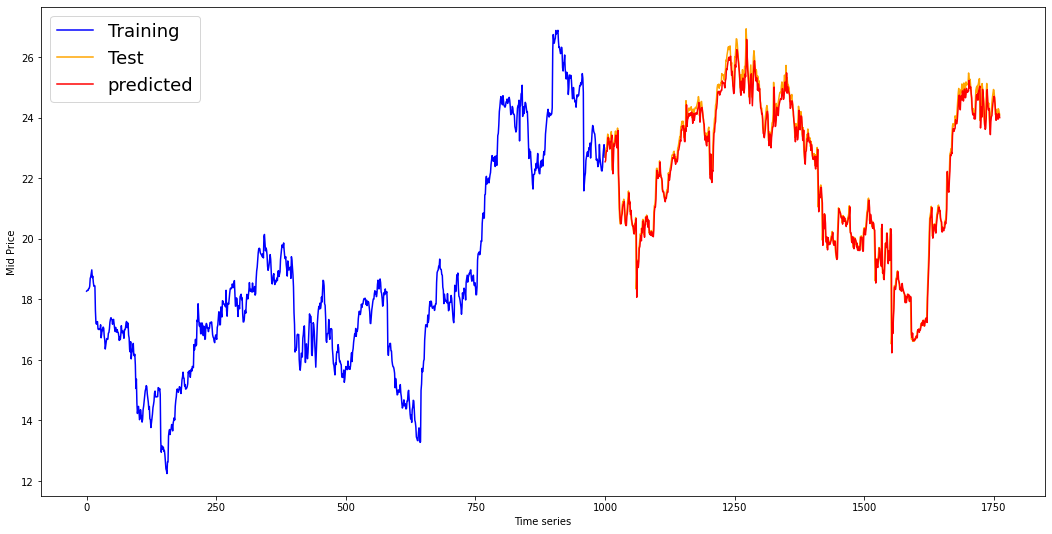

MSE: [0.12426193]


In [64]:
plt.figure(figsize = (18,9))
plt.plot(range(0,training_val.shape[0]),data_train['Mid'].to_numpy().reshape(-1,1),color='b',label='Training')
plt.plot(range(training_val.shape[0],training_val.shape[0]+test_val.shape[0]),data_test['Mid'].to_numpy().reshape(-1,1),color='orange',label='Test')
plt.plot(range(training_val.shape[0],training_val.shape[0]+predicted_stock_price.shape[0]),predicted_stock_price,color='red',label='predicted')
plt.xlabel('Time series')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

mse = ((predicted_stock_price - data_test['Mid'].to_numpy().reshape(-1,1))**2).mean(axis=0)
print('MSE: {}'.format(mse))